In [1]:
import os

import numpy as np
import cv2
import matplotlib.pyplot as plt

from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras import backend as keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler

from glob import glob
from tqdm import tqdm

/home/duilio/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
INPUT_DIR = os.path.join("/home/duilio/Descargas/" )

SEGMENTATION_DIR = os.path.join(INPUT_DIR, "segmentation")
SEGMENTATION_TEST_DIR = os.path.join(SEGMENTATION_DIR, "test")
SEGMENTATION_TRAIN_DIR = os.path.join(SEGMENTATION_DIR, "train")
SEGMENTATION_AUG_DIR = os.path.join(SEGMENTATION_TRAIN_DIR, "augmentation")
SEGMENTATION_IMAGE_DIR = os.path.join(SEGMENTATION_TRAIN_DIR, "image")
SEGMENTATION_MASK_DIR = os.path.join(SEGMENTATION_TRAIN_DIR, "mask")
SEGMENTATION_DILATE_DIR = os.path.join(SEGMENTATION_TRAIN_DIR, "dilate")
SEGMENTATION_SOURCE_DIR = os.path.join(INPUT_DIR, \
                                       "pulmonary_chest_xray_abnormalities")

SHENZHEN_TRAIN_DIR = os.path.join(SEGMENTATION_SOURCE_DIR, \
                                  "ChinaSet_AllFiles_BONE")
SHENZHEN_IMAGE_DIR = os.path.join(SHENZHEN_TRAIN_DIR, "CXR_png")
SHENZHEN_MASK_DIR = os.path.join(SHENZHEN_TRAIN_DIR, "mask")


DILATE_KERNEL = np.ones((15, 15), np.uint8)

BATCH_SIZE=2

#Prod
EPOCHS=100

#Desv
#EPOCHS=16

In [3]:
def add_colored_dilate(image, mask_image, dilate_image):
    mask_image_gray = cv2.cvtColor(mask_image, cv2.COLOR_BGR2GRAY)
    dilate_image_gray = cv2.cvtColor(dilate_image, cv2.COLOR_BGR2GRAY)
    
    mask = cv2.bitwise_and(mask_image, mask_image, mask=mask_image_gray)
    dilate = cv2.bitwise_and(dilate_image, dilate_image, mask=dilate_image_gray)
    
    mask_coord = np.where(mask!=[0,0,0])
    dilate_coord = np.where(dilate!=[0,0,0])

    mask[mask_coord[0],mask_coord[1],:]=[255,0,0]
    dilate[dilate_coord[0],dilate_coord[1],:] = [0,0,255]

    ret = cv2.addWeighted(image, 0.7, dilate, 0.3, 0)
    ret = cv2.addWeighted(ret, 0.7, mask, 0.3, 0)

    return ret

def add_colored_mask(image, mask_image):
    mask_image_gray = cv2.cvtColor(mask_image, cv2.COLOR_BGR2GRAY)
    
    mask = cv2.bitwise_and(mask_image, mask_image, mask=mask_image_gray)
    
    mask_coord = np.where(mask!=[0,0,0])

    mask[mask_coord[0],mask_coord[1],:]=[255,0,0]

    ret = cv2.addWeighted(image, 0.7, mask, 0.3, 0)

    return ret

def diff_mask(ref_image, mask_image):
    mask_image_gray = cv2.cvtColor(mask_image, cv2.COLOR_BGR2GRAY)
    
    mask = cv2.bitwise_and(mask_image, mask_image, mask=mask_image_gray)
    
    mask_coord = np.where(mask!=[0,0,0])

    mask[mask_coord[0],mask_coord[1],:]=[255,0,0]

    ret = cv2.addWeighted(ref_image, 0.7, mask, 0.3, 0)
    return ret

In [4]:
shenzhen_mask_dir = glob(os.path.join(SHENZHEN_MASK_DIR, '*.bmp'))
shenzhen_test = shenzhen_mask_dir[0:50]
shenzhen_train= shenzhen_mask_dir[50:]

for mask_file in tqdm(shenzhen_mask_dir):
    base_file = os.path.basename(mask_file).replace("_mask", "")
    image_file = os.path.join(SHENZHEN_IMAGE_DIR, base_file)

    image = cv2.imread(image_file)
    mask = cv2.imread(mask_file, cv2.IMREAD_GRAYSCALE)
        
    image = cv2.resize(image, (512, 512))
    mask = cv2.resize(mask, (512, 512))
    #mask_dilate = cv2.dilate(mask, DILATE_KERNEL, iterations=1)
    mask_dilate = mask #Con esto no hacemos ninguna dilatacion de las mascaras

    
    if (mask_file in shenzhen_train):
        cv2.imwrite(os.path.join(SEGMENTATION_IMAGE_DIR, base_file), \
                    image)
        cv2.imwrite(os.path.join(SEGMENTATION_MASK_DIR, base_file), \
                    mask)
        cv2.imwrite(os.path.join(SEGMENTATION_DILATE_DIR, base_file), \
                    mask_dilate)
    else:
        filename, fileext = os.path.splitext(base_file)

        cv2.imwrite(os.path.join(SEGMENTATION_TEST_DIR, base_file), \
                    image)
        cv2.imwrite(os.path.join(SEGMENTATION_TEST_DIR, \
                                 "%s_mask%s" % (filename, fileext)), mask)
        cv2.imwrite(os.path.join(SEGMENTATION_TEST_DIR, \
                                 "%s_dilate%s" % (filename, fileext)), mask_dilate)

100%|██████████| 442/442 [01:19<00:00,  5.53it/s]


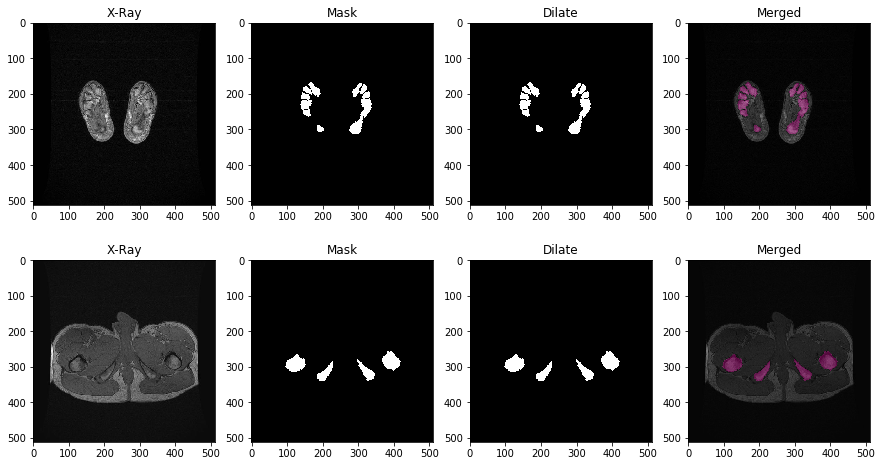

In [5]:
base_file = os.path.basename(shenzhen_train[0].replace("_mask", ""))

image_file = os.path.join(SEGMENTATION_IMAGE_DIR, base_file)
mask_image_file = os.path.join(SEGMENTATION_MASK_DIR, base_file)
dilate_image_file = os.path.join(SEGMENTATION_DILATE_DIR, base_file)

image = cv2.imread(image_file)
mask_image = cv2.imread(mask_image_file)
dilate_image = cv2.imread(dilate_image_file)
merged_image = add_colored_dilate(image, mask_image, dilate_image)
                          
fig, axs = plt.subplots(2, 4, figsize=(15, 8))

axs[0, 0].set_title("X-Ray")
axs[0, 0].imshow(image)

axs[0, 1].set_title("Mask")
axs[0, 1].imshow(mask_image)

axs[0, 2].set_title("Dilate")
axs[0, 2].imshow(dilate_image)

axs[0, 3].set_title("Merged")
axs[0, 3].imshow(merged_image)

base_file = os.path.basename(shenzhen_test[0].replace("_mask", ""))
image_file = os.path.join(SEGMENTATION_TEST_DIR, base_file)
filename, fileext = os.path.splitext(base_file)
mask_image_file = os.path.join(SEGMENTATION_TEST_DIR, \
                               "%s_mask%s" % (filename, fileext))

filename, fileext = os.path.splitext(base_file)
image_file = os.path.join(SEGMENTATION_TEST_DIR, base_file)
mask_image_file = os.path.join(SEGMENTATION_TEST_DIR, \
                               "%s_mask%s" % (filename, fileext))
dilate_image_file = os.path.join(SEGMENTATION_TEST_DIR, \
                                 "%s_dilate%s" % (filename, fileext))

image = cv2.imread(image_file)
mask_image = cv2.imread(mask_image_file)
dilate_image = cv2.imread(dilate_image_file)
merged_image = add_colored_dilate(image, mask_image, dilate_image)

axs[1, 0].set_title("X-Ray")
axs[1, 0].imshow(image)

axs[1, 1].set_title("Mask")
axs[1, 1].imshow(mask_image)

axs[1, 2].set_title("Dilate")
axs[1, 2].imshow(dilate_image)

axs[1, 3].set_title("Merged")
axs[1, 3].imshow(merged_image)
plt.show()

In [6]:
train_files = glob(os.path.join(SEGMENTATION_IMAGE_DIR, "*.bmp"))
test_files = glob(os.path.join(SEGMENTATION_TEST_DIR, "*.bmp"))
mask_files = glob(os.path.join(SEGMENTATION_MASK_DIR, "*.bmp"))
dilate_files = glob(os.path.join(SEGMENTATION_DILATE_DIR, "*.bmp"))

(len(train_files), \
 len(test_files), \
 len(mask_files), \
 len(dilate_files))

(392, 150, 392, 392)

In [9]:
# From: https://github.com/zhixuhao/unet/blob/master/data.py
def train_generator(batch_size, train_path, image_folder, mask_folder, aug_dict,
        image_color_mode="grayscale",
        mask_color_mode="grayscale",
        image_save_prefix="image",
        mask_save_prefix="mask",
        save_to_dir=None,
        target_size=(256,256),
        seed=1):
    '''
    can generate image and mask at the same time use the same seed for
    image_datagen and mask_datagen to ensure the transformation for image
    and mask is the same if you want to visualize the results of generator,
    set save_to_dir = "your path"
    '''
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    
    image_generator = image_datagen.flow_from_directory(
        train_path,
        classes = [image_folder],
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)

    mask_generator = mask_datagen.flow_from_directory(
        train_path,
        classes = [mask_folder],
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)

    train_gen = zip(image_generator, mask_generator)
    
    for (img, mask) in train_gen:
        img, mask = adjust_data(img, mask)
        yield (img,mask)

def adjust_data(img,mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    
    return (img, mask)

In [37]:
# From: https://github.com/jocicmarko/ultrasound-nerve-segmentation/blob/master/train.py
def dice_coef(y_true, y_pred):
    y_true_f = keras.flatten(y_true)
    y_pred_f = keras.flatten(y_pred)
    intersection = keras.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (keras.sum(y_true_f) + keras.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def unet(input_size=(256,256,1)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    #pool1 = Dropout(0.25)(pool1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    #pool2 = Dropout(0.5)(pool2)
    
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    #pool3 = Dropout(0.5)(pool3)
    
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    #pool4 = Dropout(0.5)(pool4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    #up6 = Dropout(0.5)(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    #up7 = Dropout(0.5)(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    #up8 = Dropout(0.5)(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    #up9 = Dropout(0.5)(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    #conv9 = Dropout(0.5)(conv9)
    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

In [11]:
# From: https://github.com/zhixuhao/unet/blob/master/data.py
def test_load_image(test_file, target_size=(256,256)):
    img = cv2.imread(test_file, cv2.IMREAD_GRAYSCALE)
    img = img / 255
    img = cv2.resize(img, target_size)
    img = np.reshape(img, img.shape + (1,))
    img = np.reshape(img,(1,) + img.shape)
    return img

def test_generator(test_files, target_size=(256,256)):
    for test_file in test_files:
        yield test_load_image(test_file, target_size)
        
def save_result(save_path, npyfile, test_files):
    for i, item in enumerate(npyfile):
        result_file = test_files[i]
        img = (item[:, :, 0] * 255.).astype(np.uint8)

        filename, fileext = os.path.splitext(os.path.basename(result_file))

        result_file = os.path.join(save_path, "%s_predict%s" % (filename, fileext))

        cv2.imwrite(result_file, img)

In [12]:
def add_suffix(base_file, suffix):
    filename, fileext = os.path.splitext(base_file)
    return "%s_%s%s" % (filename, suffix, fileext)

test_files = [test_file for test_file in glob(os.path.join(SEGMENTATION_TEST_DIR, "*.bmp")) \
              if ("_mask" not in test_file \
                  and "_dilate" not in test_file \
                  and "_predict" not in test_file)]

validation_data = (test_load_image(test_files[0], target_size=(512, 512)),
                    test_load_image(add_suffix(test_files[0], "dilate"), target_size=(512, 512)))

len(test_files), len(validation_data)

(50, 2)

In [72]:
train_generator_args = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')

train_gen = train_generator(BATCH_SIZE,
                            SEGMENTATION_TRAIN_DIR,
                            'image',
                            'dilate', 
                            train_generator_args,
                            target_size=(512,512),
                            save_to_dir=os.path.abspath(SEGMENTATION_AUG_DIR))

model = unet(input_size=(512,512,1))
model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, \
                  metrics=[dice_coef, 'binary_accuracy'])
model.summary()



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
conv2d_39 (Conv2D)              (None, 512, 512, 32) 320         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_40 (Conv2D)              (None, 512, 512, 32) 9248        conv2d_39[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_9 (MaxPooling2D)  (None, 256, 256, 32) 0           conv2d_40[0][0]                  
__________________________________________________________________________________________________
conv2d_41 

In [9]:
# Import dependencies
import json
from keras.models import model_from_json, load_model



# Option 1: Save Weights + Architecture
#model.save_weights('unet_weights.h5')
#with open('unet_architecture.json', 'w') as f:
#    f.write(model.to_json())
# Option 1: Load Weights + Architecture
with open('unet_bone_dropout_callbacks_200epoch.json', 'r') as f:
    model1 = model_from_json(f.read())

# Option 2: Save/load the entire model
#model.save('my_model.h5')
#new_model_2 = load_model('/home/duilio/Escritorio/Models_and_weights/unet_bone_dropout_callbacks_200epoch.h5')

model1.load_weights('unet_bone_NOdropout_callbacks_200epoch.hdf5')
#model.load_weights('unet_bone_dropout_callbacks_200epoch.h5')


#Tuve tremendo bloqueo tratando de cargar los modelos, la solucion pip install --upgrade keras
#(soy un hdp que no lee foros)



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 512, 512, 32) 9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 256, 256, 32) 0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
dropout_1 

In [40]:
test_gen = test_generator(test_files, target_size=(512,512))
results = model.predict_generator(test_gen, len(test_files), verbose=1)
save_result(SEGMENTATION_TEST_DIR, results, test_files)

50/50 [==============================] - 113s 2s/step


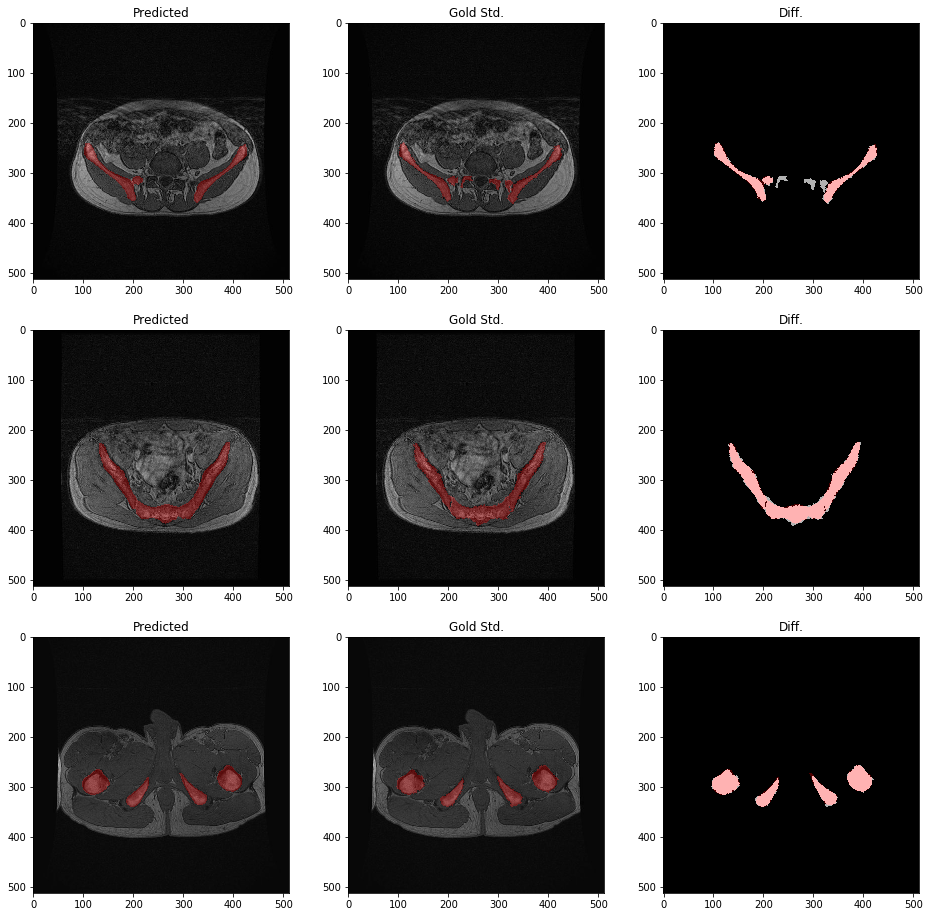

In [41]:
image = cv2.imread("/home/duilio/Descargas/segmentation/test/Imagen58.bmp")
predict_image = cv2.imread("/home/duilio/Descargas/segmentation/test/Imagen58_predict.bmp")
mask_image = cv2.imread("/home/duilio/Descargas/segmentation/test/Imagen58_dilate.bmp")

fig, axs = plt.subplots(3, 3, figsize=(16, 16))

axs[0, 0].set_title("Predicted")
axs[0, 0].imshow(add_colored_mask(image, predict_image))
axs[0, 1].set_title("Gold Std.")
axs[0, 1].imshow(add_colored_mask(image, mask_image))
axs[0, 2].set_title("Diff.")
axs[0, 2].imshow(diff_mask(mask_image, predict_image))

image = cv2.imread("/home/duilio/Descargas/segmentation/test/Imagen85.bmp")
predict_image = cv2.imread("/home/duilio/Descargas/segmentation/test/Imagen85_predict.bmp")
mask_image = cv2.imread("/home/duilio/Descargas/segmentation/test/Imagen85_dilate.bmp")

axs[1, 0].set_title("Predicted")
axs[1, 0].imshow(add_colored_mask(image, predict_image))
axs[1, 1].set_title("Gold Std.")
axs[1, 1].imshow(add_colored_mask(image, mask_image))
axs[1, 2].set_title("Diff.")
axs[1, 2].imshow(diff_mask(mask_image, predict_image))

image = cv2.imread("/home/duilio/Descargas/segmentation/test/Imagen131.bmp")
predict_image = cv2.imread("/home/duilio/Descargas/segmentation/test/Imagen131_predict.bmp")
mask_image = cv2.imread("/home/duilio/Descargas/segmentation/test/Imagen131_dilate.bmp")

axs[2, 0].set_title("Predicted")
axs[2, 0].imshow(add_colored_mask(image, predict_image))
axs[2, 1].set_title("Gold Std.")
axs[2, 1].imshow(add_colored_mask(image, mask_image))
axs[2, 2].set_title("Diff.")
axs[2, 2].imshow(diff_mask(mask_image, predict_image))

plt.show()

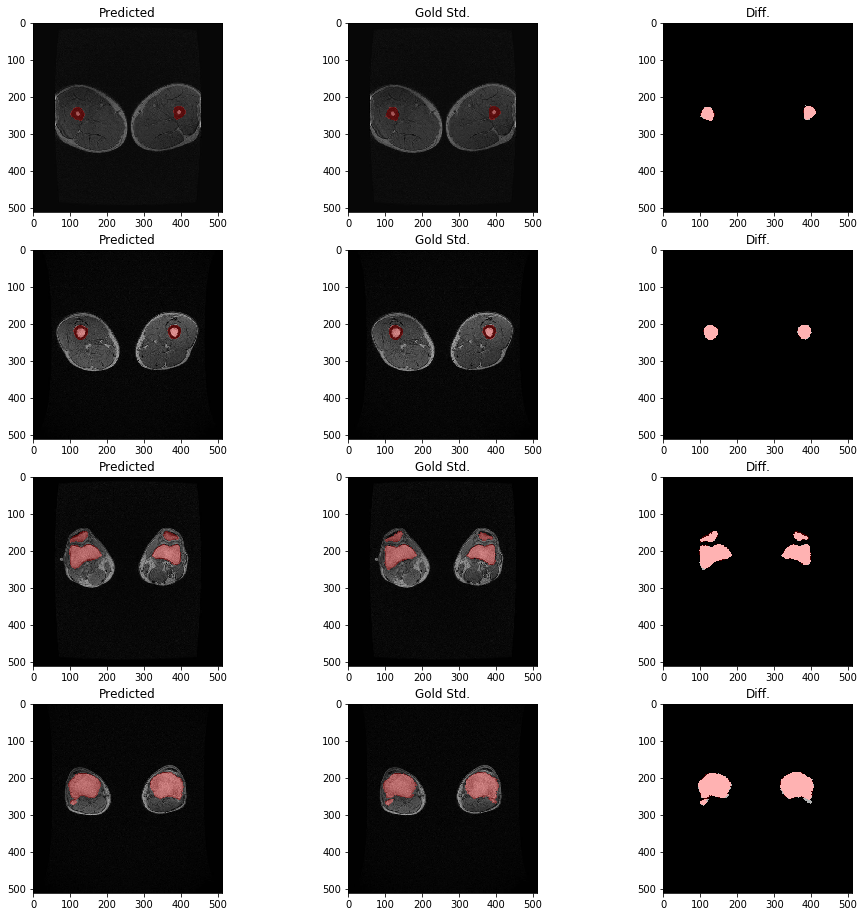

In [42]:
image = cv2.imread("/home/duilio/Descargas/segmentation/test/Imagen183.bmp")
predict_image = cv2.imread("/home/duilio/Descargas/segmentation/test/Imagen183_predict.bmp")
mask_image = cv2.imread("/home/duilio/Descargas/segmentation/test/Imagen183_dilate.bmp")

fig, axs = plt.subplots(4, 3, figsize=(16, 16))

axs[0, 0].set_title("Predicted")
axs[0, 0].imshow(add_colored_mask(image, predict_image))
axs[0, 1].set_title("Gold Std.")
axs[0, 1].imshow(add_colored_mask(image, mask_image))
axs[0, 2].set_title("Diff.")
axs[0, 2].imshow(diff_mask(mask_image, predict_image))

image = cv2.imread("/home/duilio/Descargas/segmentation/test/Imagen232.bmp")
predict_image = cv2.imread("/home/duilio/Descargas/segmentation/test/Imagen232_predict.bmp")
mask_image = cv2.imread("/home/duilio/Descargas/segmentation/test/Imagen232_dilate.bmp")

axs[1, 0].set_title("Predicted")
axs[1, 0].imshow(add_colored_mask(image, predict_image))
axs[1, 1].set_title("Gold Std.")
axs[1, 1].imshow(add_colored_mask(image, mask_image))
axs[1, 2].set_title("Diff.")
axs[1, 2].imshow(diff_mask(mask_image, predict_image))

image = cv2.imread("/home/duilio/Descargas/segmentation/test/Imagen270.bmp")
predict_image = cv2.imread("/home/duilio/Descargas/segmentation/test/Imagen270_predict.bmp")
mask_image = cv2.imread("/home/duilio/Descargas/segmentation/test/Imagen270_dilate.bmp")

axs[2, 0].set_title("Predicted")
axs[2, 0].imshow(add_colored_mask(image, predict_image))
axs[2, 1].set_title("Gold Std.")
axs[2, 1].imshow(add_colored_mask(image, mask_image))
axs[2, 2].set_title("Diff.")
axs[2, 2].imshow(diff_mask(mask_image, predict_image))

image = cv2.imread("/home/duilio/Descargas/segmentation/test/Imagen297.bmp")
predict_image = cv2.imread("/home/duilio/Descargas/segmentation/test/Imagen297_predict.bmp")
mask_image = cv2.imread("/home/duilio/Descargas/segmentation/test/Imagen297_dilate.bmp")

axs[3, 0].set_title("Predicted")
axs[3, 0].imshow(add_colored_mask(image, predict_image))
axs[3, 1].set_title("Gold Std.")
axs[3, 1].imshow(add_colored_mask(image, mask_image))
axs[3, 2].set_title("Diff.")
axs[3, 2].imshow(diff_mask(mask_image, predict_image))
plt.show()


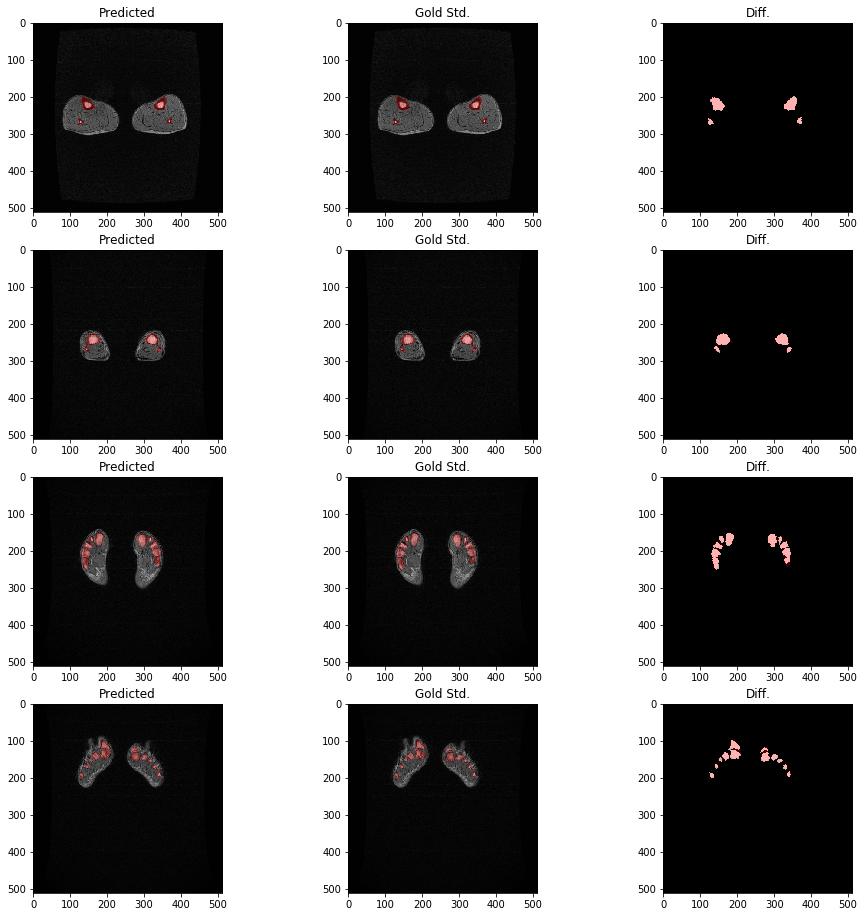

In [43]:
image = cv2.imread("/home/duilio/Descargas/segmentation/test/Imagen348.bmp")
predict_image = cv2.imread("/home/duilio/Descargas/segmentation/test/Imagen348_predict.bmp")
mask_image = cv2.imread("/home/duilio/Descargas/segmentation/test/Imagen348_dilate.bmp")

fig, axs = plt.subplots(4, 3, figsize=(16, 16))

axs[0, 0].set_title("Predicted")
axs[0, 0].imshow(add_colored_mask(image, predict_image))
axs[0, 1].set_title("Gold Std.")
axs[0, 1].imshow(add_colored_mask(image, mask_image))
axs[0, 2].set_title("Diff.")
axs[0, 2].imshow(diff_mask(mask_image, predict_image))

image = cv2.imread("/home/duilio/Descargas/segmentation/test/Imagen419.bmp")
predict_image = cv2.imread("/home/duilio/Descargas/segmentation/test/Imagen419_predict.bmp")
mask_image = cv2.imread("/home/duilio/Descargas/segmentation/test/Imagen419_dilate.bmp")

axs[1, 0].set_title("Predicted")
axs[1, 0].imshow(add_colored_mask(image, predict_image))
axs[1, 1].set_title("Gold Std.")
axs[1, 1].imshow(add_colored_mask(image, mask_image))
axs[1, 2].set_title("Diff.")
axs[1, 2].imshow(diff_mask(mask_image, predict_image))

image = cv2.imread("/home/duilio/Descargas/segmentation/test/Imagen476.bmp")
predict_image = cv2.imread("/home/duilio/Descargas/segmentation/test/Imagen476_predict.bmp")
mask_image = cv2.imread("/home/duilio/Descargas/segmentation/test/Imagen476_dilate.bmp")

axs[2, 0].set_title("Predicted")
axs[2, 0].imshow(add_colored_mask(image, predict_image))
axs[2, 1].set_title("Gold Std.")
axs[2, 1].imshow(add_colored_mask(image, mask_image))
axs[2, 2].set_title("Diff.")
axs[2, 2].imshow(diff_mask(mask_image, predict_image))
image = cv2.imread("/home/duilio/Descargas/segmentation/test/Imagen492.bmp")
predict_image = cv2.imread("/home/duilio/Descargas/segmentation/test/Imagen492_predict.bmp")
mask_image = cv2.imread("/home/duilio/Descargas/segmentation/test/Imagen492_dilate.bmp")

axs[3, 0].set_title("Predicted")
axs[3, 0].imshow(add_colored_mask(image, predict_image))
axs[3, 1].set_title("Gold Std.")
axs[3, 1].imshow(add_colored_mask(image, mask_image))
axs[3, 2].set_title("Diff.")
axs[3, 2].imshow(diff_mask(mask_image, predict_image))

plt.show()
